
# **Lecture 4 Lab Notebook**

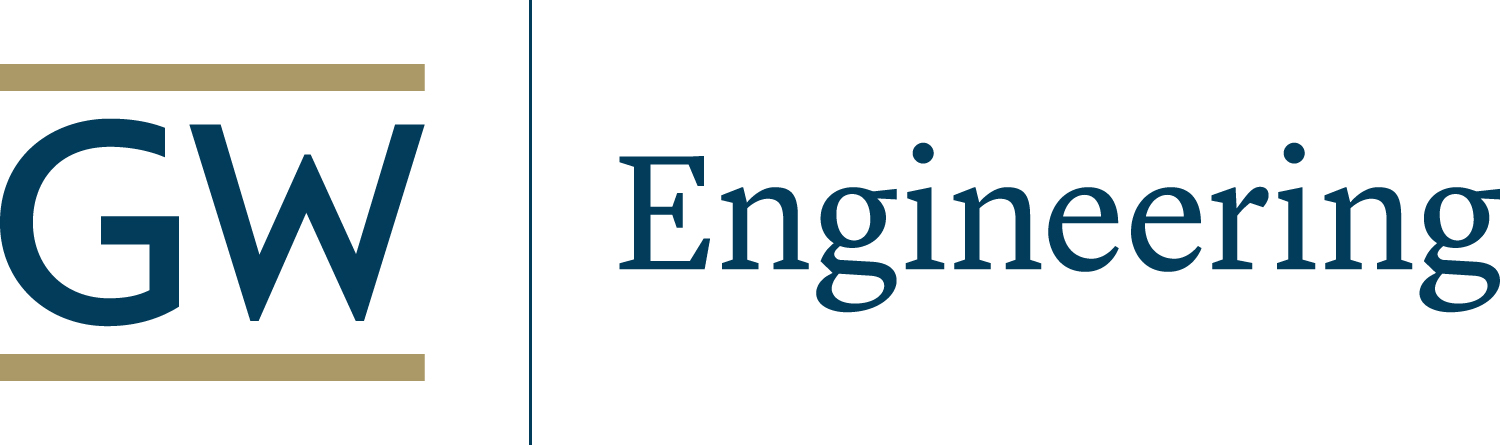

In [2]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

LABELS = ["Normal", "Fraud"]

Lets generate some sythetic data to learn with

In [ ]:
# # Parameters
# n_samples = 10000
# n_outliers = int(0.05 * n_samples)  # 5% outliers
# n_inliers = n_samples - n_outliers
# n_features = 20  # Number of features
# purturbation = 2
# # Generate inliers
# X_inliers, y_inliers = make_blobs(
#     n_samples=n_inliers, centers=3, n_features=n_features, cluster_std=1.5, random_state=42
# )

# # Generate outliers harder to detect (within the same distribution as inliers)
# X_outliers = X_inliers[np.random.choice(X_inliers.shape[0], n_outliers, replace=False)]
# X_outliers += np.random.normal(0, purturbation, size=X_outliers.shape)  # Slight random perturbation

# # Combine inliers and outliers
# X = np.vstack((X_inliers, X_outliers))
# y = np.hstack((np.zeros(n_inliers), np.ones(n_outliers)))  # 0 for inliers, 1 for outliers

# # Convert to DataFrame for exploration
# columns = [f"Feature{i+1}" for i in range(n_features)]
# df = pd.DataFrame(X, columns=columns)
# df["Class"] = y
# print(df.head())
# print(f"Shape of dataset: {df.shape}")


   Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0  3.940341 -5.627795 -5.400168 -2.874870 -0.303714  6.925473 -5.724213   
1 -8.304869  0.226904 -7.887974  5.950937 -3.133699  3.379946 -3.936539   
2 -3.352420  8.568961  5.172261  4.165096 -7.133306 -8.174301 -5.960024   
3 -7.023209  7.691721  3.848275  0.239702 -6.016757 -8.046281 -8.120688   
4 -3.235747  6.737443  6.993928  1.095063 -8.193996 -7.546760 -7.445081   

   Feature8  Feature9  Feature10  ...  Feature12  Feature13  Feature14  \
0  2.015699  1.731386  -6.750876  ...  -6.480604  -8.136016   7.567211   
1  0.005197  3.138350  -6.829766  ...   4.706732   8.832867   8.175991   
2  7.526849  1.863409   4.269203  ...   9.330089   7.788265  -3.923037   
3  5.473543  3.386129   2.246728  ...  11.254091   5.365012  -3.117824   
4  7.492863  0.834801   4.775176  ...   9.362550   6.296711  -4.229404   

   Feature15  Feature16  Feature17  Feature18  Feature19  Feature20  Class  
0   9.055622   6.436444  -2

In [28]:
df = pd.read_csv('/Users/ken.clements/code/SEAS8416/data/creditcard.csv')

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_75161/2266408853.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

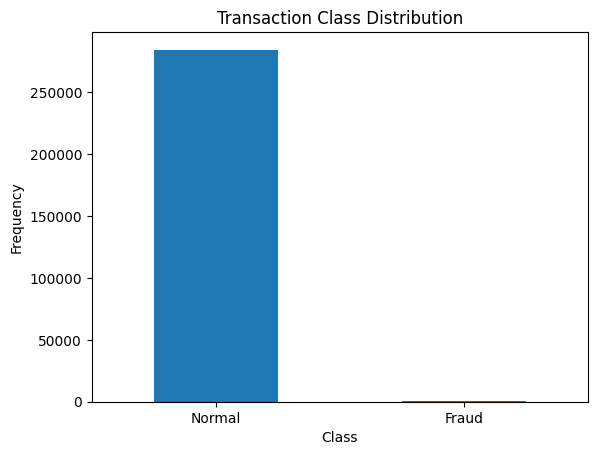

In [29]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [30]:
imbalance = (df['Class'] == 1).sum() / ((df['Class'] == 0).sum() + (df['Class'] == 1).sum())
print(f"The class imbalance is {imbalance}")

The class imbalance is 0.001727485630620034


In [31]:
X = df.drop(columns = 'Class')
y = df['Class']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify retains the class balance - important for imbalnced data

In [33]:
len(X_test)

85443

In [34]:
len(X_train)

199364

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

In [36]:
# Define the custom F1 scorer function (directly handle y_true and predictions)
def custom_f1_score(estimator, X, y_true):

    # Get the predictions: -1 for outliers, 1 for inliers
    try:
        y_pred = estimator.predict(X)
    except:
        y_pred = estimator.fit_predict(X)
    
    # Convert predictions from {-1, 1} to binary {0, 1} for F1 score calculation
    y_pred_binary = np.where(y_pred == -1, 1, 0)  # Convert -1 (outliers) to 1 and 1 (inliers) to 0
    
    # Ensure y_true is in binary format (outliers = 0, inliers = 1)
    # y_true_binary = np.where(y_true == 1, 0, 1)  # Convert outliers to 0 and inliers to 1
    
    # Calculate F1 score
    return f1_score(y_true, y_pred_binary)


In [37]:
# Define the Isolation Forest model
iso_forest = IsolationForest(random_state=42)

# Use GridSearchCV with the custom F1 scorer
param_grid_iforest = {
    'n_estimators': [50, 100, 200],
    'max_samples': [.5, 0.75],
    'contamination': [.01, .05, .1],
    'max_features': [0.5, .75]
    # 'n_estimators': [50],
    # 'max_samples': [.75],
    # 'contamination': [.0017],
    # 'max_features': [.5]
}

grid_search_iforest = GridSearchCV(iso_forest, param_grid_iforest, scoring=custom_f1_score, cv=3, verbose=2)
grid_search_iforest.fit(X_train_scaled, y_train)

best_model = grid_search_iforest.best_estimator_

# Output best parameters and best F1 score
print("Best Parameters:", grid_search_iforest.best_params_)
print("Best F1 Score:", grid_search_iforest.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.6s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.6s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.6s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   3.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   3.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   3.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   6.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   6.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   6.2s
[CV] END contamination=0.01, max

In [38]:
print("Best Parameters:", grid_search_iforest.best_params_)
print("Best F1 Score:", grid_search_iforest.best_score_)

Best Parameters: {'contamination': 0.01, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 200}
Best F1 Score: 0.2126094280330146


In [39]:
grid_search_iforest.best_estimator_

IsolationForest(contamination=0.01, max_features=0.5, max_samples=0.75,
                n_estimators=200, random_state=42)

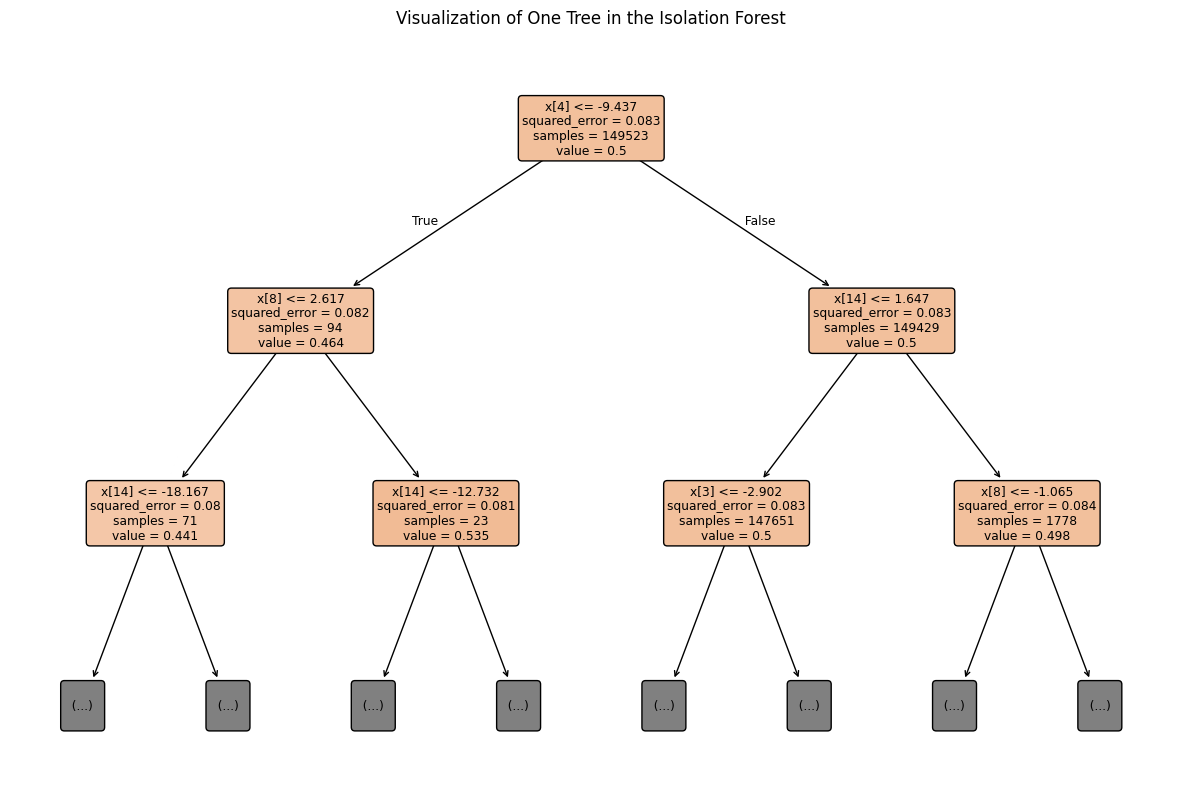

In [40]:
from sklearn.tree import plot_tree

tree = grid_search_iforest.best_estimator_.estimators_[4]  # Get the first tree

# Visualize the tree
plt.figure(figsize=(15, 10))
plot_tree(tree, filled=True, rounded=True, max_depth=2)
plt.title("Visualization of One Tree in the Isolation Forest")
plt.show()

In [41]:
lof = LocalOutlierFactor(n_neighbors=20)

# Define the parameter grid for GridSearchCV
param_grid_lof = {
    'n_neighbors': [10, 20, 30],  # Number of neighbors to use for LOF
    'contamination': [0.01, 0.05, 0.1],  # Proportion of outliers
    'leaf_size': [30, 40, 50]  # Leaf size for the tree-based algorithm used in LOF
    # 'n_neighbors': [10],  # Number of neighbors to use for LOF
    # 'contamination': [0.0017],  # Proportion of outliers
    # 'leaf_size': [30]  # Leaf size for the tree-based algorithm used in LOF
}

# Perform GridSearchCV with the custom F1 scorer
grid_search_lof = GridSearchCV(lof, param_grid_lof, scoring=custom_f1_score, cv=3, verbose=2)
grid_search_lof.fit(X_train_scaled, y_train)

# Output best parameters and best F1 score
print("Best Parameters:", grid_search_lof.best_params_)
print("Best F1 Score:", grid_search_lof.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=10; total time=   7.7s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=10; total time=   8.0s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=10; total time=   7.9s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=20; total time=   8.0s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=20; total time=   8.3s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=20; total time=   7.6s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=30; total time=   7.6s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=30; total time=   7.9s
[CV] END ...contamination=0.01, leaf_size=30, n_neighbors=30; total time=   7.5s
[CV] END ...contamination=0.01, leaf_size=40, n_neighbors=10; total time=   7.4s
[CV] END ...contamination=0.01, leaf_size=40, n_neighbors=10; total time=   7.4s
[CV] END ...contamination=0.01, leaf_size=40, n_

In [42]:
grid_search_lof.best_params_

{'contamination': 0.01, 'leaf_size': 30, 'n_neighbors': 30}

In [43]:
grid_search_lof.best_estimator_

LocalOutlierFactor(contamination=0.01, n_neighbors=30)

In [44]:
# Custom scoring function using silhouette score
def silhouette_scorer(estimator, X):
    # Fit the model and predict labels
    labels = estimator.fit_predict(X)
    # The silhouette score is not defined if only one cluster is found
    if len(set(labels)) > 1:  # Check if there are multiple clusters
        return silhouette_score(X, labels)
    else:
        return -1  # Return a low score if there is only one cluster
    
# # Create a scorer object
# scorer = make_scorer(silhouette_scorer, greater_is_better=True)


## What is a silhouette score?

1. For each data point, the average distance (a_i) to other data points within the same cluster is calculated. This value represents the similarity level of the data point to others in its cluster.

2. For each data point, the average distance (b_i) to all other clusters it doesn’t belong to is computed. This value indicates how different the data point is from data points in other clusters.

3. The Silhouette score is calculated using the formula:

Silhouette Score = (b_i — a_i) / max(a_i, b_i)

In [45]:

# Define the parameter grid
param_grid_ocsvm = {
    'kernel': ['linear'],  # Different kernels
    'nu': [0.01, .05, .1],  # The fraction of outliers
    # 'gamma': [0.1, 1],  # Only for 'rbf' kernel
    # 'degree': [3, 4],  # Only for 'poly' kernel
    # 'kernel': ['linear'],  # Different kernels
    # 'nu': [0.05],  # The fraction of outliers
    # 'gamma': [.1],  # Only for 'rbf' kernel
    # 'degree': [3],  # Only for 'poly' kernel
    # 'max_iter': [-1] #keep going till converges
}

# Define the OCSVM model
ocsvm = OneClassSVM()

# Perform GridSearchCV
grid_search_ocsvm = GridSearchCV(ocsvm, param_grid_ocsvm, cv=3, verbose=2, scoring=silhouette_scorer)
grid_search_ocsvm.fit(X_train_scaled)

# Access the best model
best_estimator_ocsvm = grid_search_ocsvm.best_estimator_

# Print the best parameters and best score
print("Best Parameters:", grid_search_ocsvm.best_params_)
print("Best Score:", grid_search_ocsvm.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .............................kernel=linear, nu=0.01; total time=  34.7s
[CV] END .............................kernel=linear, nu=0.01; total time=  34.9s
[CV] END .............................kernel=linear, nu=0.01; total time=  34.1s
[CV] END .............................kernel=linear, nu=0.05; total time=  43.9s
[CV] END .............................kernel=linear, nu=0.05; total time=  45.3s
[CV] END .............................kernel=linear, nu=0.05; total time=  45.3s
[CV] END ..............................kernel=linear, nu=0.1; total time=  59.4s
[CV] END ..............................kernel=linear, nu=0.1; total time= 1.1min
[CV] END ..............................kernel=linear, nu=0.1; total time= 1.0min
Best Parameters: {'kernel': 'linear', 'nu': 0.1}
Best Score: 0.44968038554840456


In [46]:
# DBSCAN model
dbscan = DBSCAN()

# Custom scorer function for F1 score
def custom_f1_scorer(estimator, X, y_true):
    y_pred = estimator.fit_predict(X)
    y_pred_binary = (y_pred == -1).astype(int)  # Convert DBSCAN output (-1 for outliers) to 1 for outliers
    return f1_score(y_true, y_pred_binary)

# Create custom scorer
scorer = make_scorer(custom_f1_scorer, greater_is_better=True)

# Grid search over DBSCAN hyperparameters
param_grid = {
    'eps': [.01, .05, 1, 2],      # Maximum distance for neighbors
    'min_samples': [2, 3],         # Minimum number of points to form a dense region
#     'eps': [.3],      # Maximum distance for neighbors
#     'min_samples': [3],         # Minimum number of points to form a dense region
}

grid_search_dbs = GridSearchCV(dbscan, param_grid, scoring=custom_f1_scorer, cv=3, verbose=2)
grid_search_dbs.fit(X_train_scaled, y_train)


# Best parameters and score
print("Best Parameters:", grid_search_dbs.best_params_)
print("Best F1 Score:", grid_search_dbs.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ............................eps=0.01, min_samples=2; total time=   6.0s
[CV] END ............................eps=0.01, min_samples=2; total time=   6.3s
[CV] END ............................eps=0.01, min_samples=2; total time=   6.1s
[CV] END ............................eps=0.01, min_samples=3; total time=   6.2s
[CV] END ............................eps=0.01, min_samples=3; total time=   6.2s
[CV] END ............................eps=0.01, min_samples=3; total time=   6.1s
[CV] END ............................eps=0.05, min_samples=2; total time=   6.0s
[CV] END ............................eps=0.05, min_samples=2; total time=   6.2s
[CV] END ............................eps=0.05, min_samples=2; total time=   6.1s
[CV] END ............................eps=0.05, min_samples=3; total time=   6.1s
[CV] END ............................eps=0.05, min_samples=3; total time=   6.0s
[CV] END ............................eps=0.05, mi

In [47]:
classifiers = {
    "Isolation Forest":grid_search_iforest.best_estimator_,
    "Local Outlier Factor":grid_search_lof.best_estimator_,
    "One Class SVM":grid_search_ocsvm.best_estimator_,
    "DBSCAN":grid_search_dbs.best_estimator_
}

/Users/ken.clements/code/SEAS8416/SEAS8416/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 818
Accuracy Score :
0.990426366115422
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.12      0.68      0.20       148

    accuracy                           0.99     85443
   macro avg       0.56      0.84      0.60     85443
weighted avg       1.00      0.99      0.99     85443



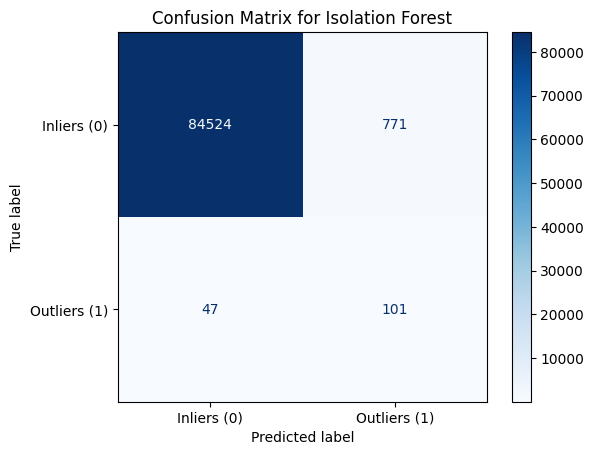

Local Outlier Factor: 987
Accuracy Score :
0.9884484393104175
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.01      0.05      0.02       148

    accuracy                           0.99     85443
   macro avg       0.50      0.52      0.51     85443
weighted avg       1.00      0.99      0.99     85443



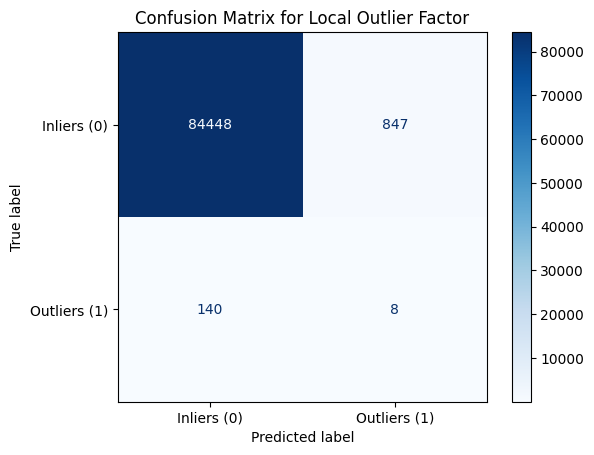

One Class SVM: 43994
Accuracy Score :
0.48510703041793946
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.49      0.65     85295
           1       0.00      0.22      0.00       148

    accuracy                           0.49     85443
   macro avg       0.50      0.35      0.33     85443
weighted avg       1.00      0.49      0.65     85443



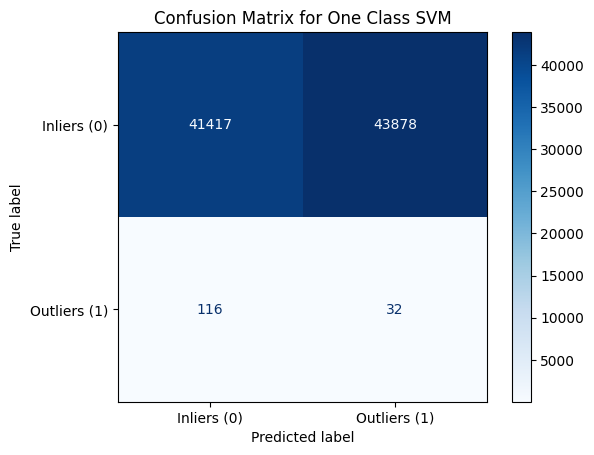

DBSCAN: 17950
Accuracy Score :
0.7899184251489297
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     85295
           1       0.01      0.78      0.01       148

    accuracy                           0.79     85443
   macro avg       0.50      0.79      0.45     85443
weighted avg       1.00      0.79      0.88     85443



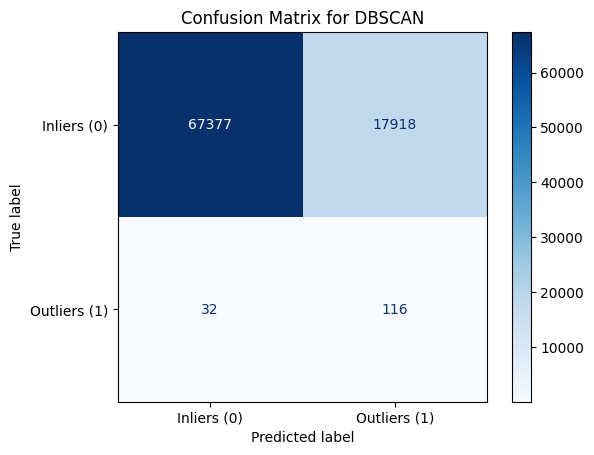

In [48]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor" :
        y_pred = clf.fit_predict(X_test_scaled)
        # scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "DBSCAN" :
        y_pred = clf.fit_predict(X_test_scaled)
        y_pred = (y_pred == -1).astype(int)  # Convert DBSCAN output (-1 for outliers) to 1 for outliers

    elif clf_name == "One Class SVM":
        # clf.fit(X)
        y_pred = clf.predict(X_test_scaled)
    else:    
        clf.fit(X)
        scores_prediction = clf.predict(X_test_scaled)
        y_pred = clf.predict(X_test)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    if clf_name != "DBSCAN":
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_test).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_test,y_pred))
    print("Classification Report :")
    print(classification_report(y_test,y_pred))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.show()


Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize, and thus make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process.

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

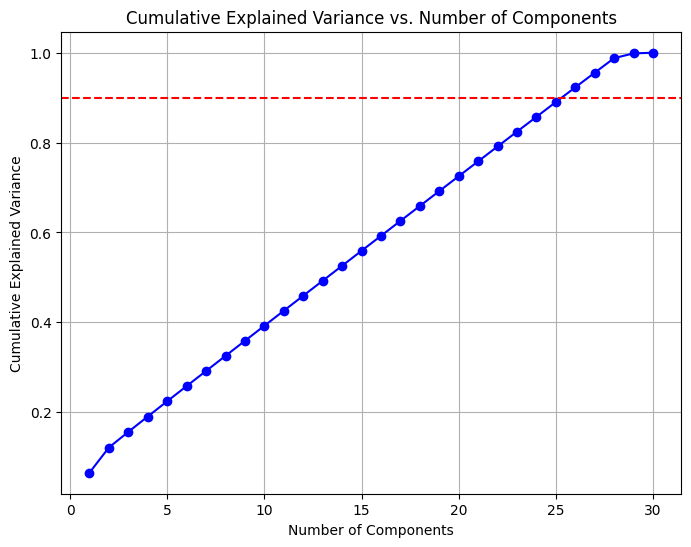

Number of components to retain 90% variance: 26
Original training data shape: (199364, 30)
Transformed training data shape: (199364, 26)
Original test data shape: (85443, 30)
Transformed test data shape: (85443, 26)


In [49]:
pca = PCA()
pca.fit(X_train_scaled)

# Step 5: Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Step 6: Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 7: Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='b')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--')  # 90% threshold
plt.show()

# Step 8: Choose the number of components that explain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.9) + 1  # Add 1 because index is 0-based
print(f"Number of components to retain 90% variance: {n_components}")

# Step 9: Transform the training and test data using the optimal number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) # again do not fit on the test set.  that leaks information from train.

# Step 10: Print the shape of the transformed data
print(f"Original training data shape: {X_train_scaled.shape}")
print(f"Transformed training data shape: {X_train_pca.shape}")
print(f"Original test data shape: {X_test_scaled.shape}")
print(f"Transformed test data shape: {X_test_pca.shape}")


In [ ]:
# Define the Isolation Forest model
iso_forest = IsolationForest(random_state=42)
grid_search_iforest = GridSearchCV(iso_forest, param_grid_iforest, scoring=custom_f1_score, cv=3, verbose=2)
grid_search_iforest.fit(X_train_pca, y_train)

# Define the LoF model
lof = LocalOutlierFactor(n_neighbors=20)
grid_search_lof = GridSearchCV(lof, param_grid_lof, scoring=custom_f1_score, cv=3, verbose=2)
grid_search_lof.fit(X_train_pca, y_train)

# Define the OCSVM model
ocsvm = OneClassSVM()
grid_search_ocsvm = GridSearchCV(ocsvm, param_grid_ocsvm, cv=3, verbose=2, scoring=silhouette_scorer)
grid_search_ocsvm.fit(X_train_pca)

# DBSCAN model
dbscan = DBSCAN()
grid_search_dbs = GridSearchCV(dbscan, param_grid, scoring=custom_f1_scorer, cv=3, verbose=2)
grid_search_dbs.fit(X_train_pca, y_train)


classifiers = {
    "Isolation Forest":grid_search_iforest.best_estimator_,
    "Local Outlier Factor":grid_search_lof.best_estimator_,
    "One Class SVM":grid_search_ocsvm.best_estimator_,
    "DBSCAN":grid_search_dbs.best_estimator_
}

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor" :
        y_pred = clf.fit_predict(X_test_pca)
        # scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "DBSCAN" :
        y_pred = clf.fit_predict(X_test_pca)
        y_pred = (y_pred == -1).astype(int)  # Convert DBSCAN output (-1 for outliers) to 1 for outliers

    elif clf_name == "One Class SVM":
        # clf.fit(X)
        y_pred = clf.predict(X_test_pca)
    else:    
        # clf.fit(X_test_pca)
        scores_prediction = clf.predict(X_test_pca)
        y_pred = clf.predict(X_test_pca)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    if clf_name != "DBSCAN":
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_test).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_test,y_pred))
    print("Classification Report :")
    print(classification_report(y_test,y_pred))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.show()


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.4s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.4s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   2.8s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   2.8s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   2.8s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   5.6s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   5.6s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   5.7s
[CV] END contamination=0.01, max

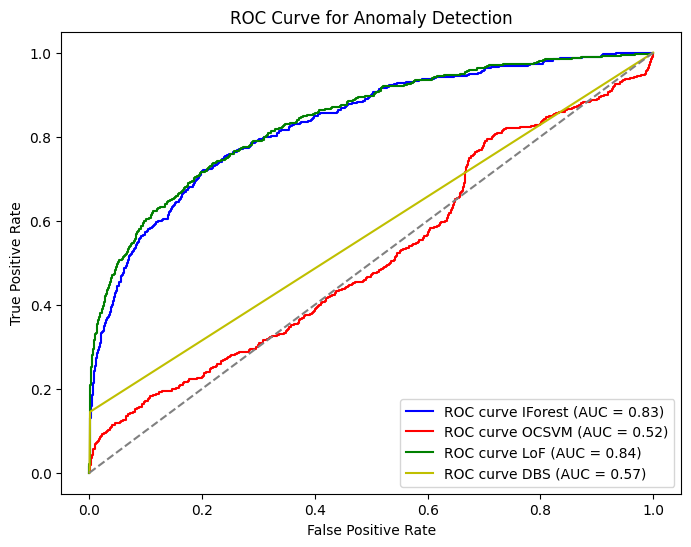

In [ ]:
y_scores_if = grid_search_iforest.best_estimator_.decision_function(X_test_pca)  # Anomaly score (the decision function)
y_scores_ocsvm = grid_search_ocsvm.best_estimator_.decision_function(X_test_pca)  # Anomaly score (the decision function)
y_scores_lof = grid_search_lof.best_estimator_.negative_outlier_factor_  # Anomaly score (the decision function)
y_scores_dbs = grid_search_dbs.best_estimator_.labels_  # Anomaly score (the decision function)

y_scores_if = -y_scores_if
y_scores_ocsvm = -y_scores_ocsvm
y_scores_lof = -y_scores_lof
y_scores_dbs = (y_scores_dbs == -1).astype(int)


fpr_if, tpr_if, _ = roc_curve(y_test, y_scores_if)  # True Positive Rate, False Positive Rate
roc_auc_if = auc(fpr_if, tpr_if)  # Compute the AUC (Area Under Curve)

fpr_ocsvm, tpr_ocsvm, _ = roc_curve(y_test, y_scores_ocsvm)  # True Positive Rate, False Positive Rate
roc_auc_ocsvm = auc(fpr_ocsvm, tpr_ocsvm)  # Compute the AUC (Area Under Curve)

fpr_lof, tpr_lof, _ = roc_curve(y_test, y_scores_lof)  # True Positive Rate, False Positive Rate
roc_auc_lof = auc(fpr_lof, tpr_lof)  # Compute the AUC (Area Under Curve)

fpr_dbs, tpr_dbs, _ = roc_curve(y_test, y_scores_dbs)  # True Positive Rate, False Positive Rate
roc_auc_dbs = auc(fpr_dbs, tpr_dbs)  # Compute the AUC (Area Under Curve)


plt.figure(figsize=(8, 6))
plt.plot(fpr_if, tpr_if, color='b', label=f'ROC curve IForest (AUC = {roc_auc_if:.2f})')
plt.plot(fpr_ocsvm, tpr_ocsvm, color='r', label=f'ROC curve OCSVM (AUC = {roc_auc_ocsvm:.2f})')
plt.plot(fpr_lof, tpr_lof, color='g', label=f'ROC curve LoF (AUC = {roc_auc_lof:.2f})')
plt.plot(fpr_dbs, tpr_dbs, color='y', label=f'ROC curve DBS (AUC = {roc_auc_dbs:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve for Anomaly Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()